In [1]:
#####Hierarchical dirichlet process context detection model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

In [3]:
####データの生成####
##データの設定
k = 10
hh = 5000
item = 3000
context = 20
Lambda = np.random.gamma(30.0, 1/0.2, hh)
pt = np.random.poisson(Lambda, hh)
hhpt = np.sum(pt)
k_vec = np.repeat(1.0, k)

In [4]:
##IDとインデックスを作成
#IDの作成
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
d_list = [i for i in range(hh)]
d_vec = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")
    d_vec[i] = np.repeat(1, d_list[i].shape[0])
d_dt = sparse.coo_matrix((np.repeat(1, hhpt), (d_id, range(hhpt))), shape=(hh, hhpt)).tocsr() 

In [5]:
##アイテムの割当を生成
#トピック割当を生成
topic = 25
phi_item = np.random.dirichlet(np.repeat(0.5, item), topic)
theta_item = np.random.dirichlet(np.repeat(0.5, topic), hh)
s = np.dot(np.array([np.random.multinomial(1, theta_item[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id[d_list[i]] = np.dot(np.random.multinomial(1, phi_item[s[i], :], pt[i]), range(item))
item_dt = sparse.coo_matrix((np.repeat(1, hhpt), (item_id, range(hhpt))), shape=(item, hhpt)).tocsr()   #スパース行列の設定
item_n = np.array(np.sum(item_dt, axis=1)).reshape(-1)

#アイテムのインデックスを定義
item_list = [i for i in range(item)]
item_n = [i for i in range(item)]
for i in range(item):
    item_list[i] = np.array(np.where(item_id==i)[0], dtype="int")
    item_n[i] = np.repeat(1, item_list[i].shape[0])

0
1000
2000
3000
4000


In [6]:
##応答変数の生成
#contextを生成
theta = np.random.dirichlet(np.repeat(0.2, context), hh)   #context分布
thetat = theta.copy()
result_true = rmnom(theta[d_id, ], hhpt, context, 1)
context_id = result_true[0]
Context = result_true[1]

#モデルパラメータの生成
beta_u = np.random.gamma(0.2, 1/0.75, hh)
beta_v = np.random.gamma(0.25, 1/0.7, item)
theta_u = np.random.gamma(0.3, 1/0.7, hh*k).reshape(hh, k)
theta_v = np.random.gamma(0.3, 1/0.75, item*k).reshape(item, k)
theta_e = np.random.gamma(0.15, 1/0.3, context*k).reshape(context, k)
betat_u = beta_u.copy(); betat_v = beta_v.copy()
thetat_u = theta_u.copy(); thetat_v = theta_v.copy(); thetat_e = theta_e.copy()

#モデルの期待値
uv1 = np.dot(theta_u[d_id, ] * theta_v[item_id, ], k_vec)
uv2 = np.dot(theta_v[item_id, ] * theta_e[context_id, ], k_vec)
mu = beta_u[d_id] + beta_v[item_id] + uv1 + uv2

#ポアソン分布から応答変数を生成
y = np.random.poisson(mu, hhpt)
y_vec = y[:, np.newaxis]

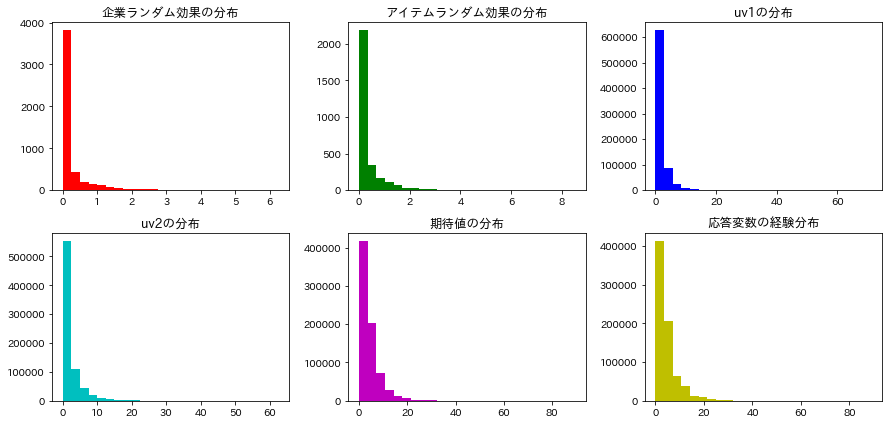

In [7]:
#生成したデータのヒストグラム
dt = [beta_u, beta_v, uv1, uv2, mu, y]
fig_range = np.append(np.array([np.min(beta_u), np.min(beta_v), np.min(uv1), np.min(uv2), np.min(mu), np.min(y)]), 
                      np.array([np.max(beta_u), np.max(beta_v), np.max(uv1), np.max(uv2), np.max(mu), np.max(y)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["企業ランダム効果の分布", "アイテムランダム効果の分布", "uv1の分布", "uv2の分布", 
          "期待値の分布", "応答変数の経験分布"]
fig = plt.figure(figsize=(12.5, 6.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [11]:
####階層ディリクレ過程モデルを推定####
##アルゴリズムの設定
context_max = 50
R = 2000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10

In [41]:
##事前分布の設定
#CRFの事前分布
gamma1 = 1.0
gamma2 = 10.0

#モデルパラメータの事前分布
alpha1 = 0.1; beta1 = 0.1
alpha2 = 0.1; beta2 = 0.1
alpha3 = 0.1; beta3 = 0.1

In [42]:
##パラメータの真値
#contextを生成
context = 25
theta = thetat.copy()
context_id = result_true[0]
Context = result_true[1]

#モデルパラメータの真値
intercept = np.repeat(1.0, hhpt)[:, np.newaxis]
beta_u = betat_u.copy()
beta_v = betat_v.copy()
theta_u = thetat_u.copy()
theta_v = thetat_v.copy()
theta_e = thetat_e.copy()

#モデルの期待値
beta_user = beta_u[d_id]; beta_item = beta_v[item_id]
theta_user = theta_u[d_id, ]; theta_item = theta_v[item_id, ]; theta_context = theta_e[context_id, ]
uv1 = np.dot(theta_user * theta_item, k_vec)
uv2 = np.dot(theta_item * theta_context, k_vec)
mu = beta_user + beta_item + uv1 + uv2
mut = mu.copy()

In [43]:
##パラメータの初期値
#contextを生成
context = 5
theta = np.random.dirichlet(np.repeat(2.0, context), hh)
res = rmnom(theta[d_id, ], hhpt, context, 1)
context_id = res[0]
Context = res[1]

#モデルパラメータの初期値
intercept = np.repeat(1.0, hhpt)[:, np.newaxis]
beta_u = np.random.gamma(0.2, 1/1.0, hh)
beta_v = np.random.gamma(0.25, 1/1.0, item)
theta_u = np.random.gamma(0.25, 1/1.0, hh*k).reshape(hh, k)
theta_v = np.random.gamma(0.3, 1/1.0, item*k).reshape(item, k)
theta_e = np.random.gamma(0.25, 1/1.0, context*k).reshape(context, k)

#モデルの期待値
beta_user = beta_u[d_id]; beta_item = beta_v[item_id]
theta_user = theta_u[d_id, ]; theta_item = theta_v[item_id, ]; theta_context = theta_e[context_id, ]
uv1 = np.dot(theta_user * theta_item, k_vec)
uv2 = np.dot(theta_item * theta_context, k_vec)
mu = beta_user + beta_item + uv1 + uv2

In [44]:
##パラメータの格納用配列
#モデルパラメータの格納用配列
BETA_U = np.zeros((int(R/keep), hh))
BETA_V = np.zeros((int(R/keep), item))
THETA_U = np.zeros((hh, k, int(R/keep)))
THETA_V = np.zeros((item, k, int(R/keep)))
THETA_E = np.zeros((context_max, k, int(R/keep)))

#潜在変数の格納用配列
THETA = np.zeros((hh, context_max, int(R/keep)))
CONTEXT = np.zeros((hhpt, context_max), dtype="int8")
CONTEXT_VEC = np.zeros((hhpt, int(R/keep)), dtype="int")

In [45]:
##対数尤度の基準値
#1パラメータモデルの対数尤度
LLst = np.sum(scipy.stats.poisson.logpmf(y, np.mean(y)))
print(LLst)

#真値での対数尤度
LLbest = np.sum(scipy.stats.poisson.logpmf(y, mut))
print(LLbest)

-2653451.9828824424
-1441098.2773775575


In [46]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    ##CRFでcontextをサンプリング
    #階層的事前分布を定義
    global_prob1 = np.sum(Context, axis=0) / (hhpt + gamma2)
    global_prob2 = gamma2 / (hhpt + gamma2)
    Prior = np.zeros((hh, context))
    for i in range(hh):
        local_prob1 = np.sum(Context[d_list[i], ], axis=0) / (pt[i] + gamma1)
        local_prob2 = gamma1 / (pt[i] + gamma1)
        Prior[i, ] = local_prob1 + local_prob2 * global_prob1

    #新しいパラメータをサンプリング
    if context <= context_max:
        Prior = np.hstack((Prior, np.repeat(local_prob2 * global_prob2, hh)[:, np.newaxis]))
        new_theta = np.vstack((theta_e, np.random.gamma(0.25, 1/0.75, k)))
    new_context = new_theta.shape[0]

    #contextパターンごとの尤度を定義
    theta_item = theta_v[item_id, ] 
    uv_pattern = np.zeros((hhpt, new_context))
    for j in range(new_context):
        uv_pattern[:, j] = np.dot(theta_item * new_theta[j, ], k_vec)
    mu_pattern = beta_u[d_id][:, np.newaxis] + beta_v[item_id][:, np.newaxis] + uv1[:, np.newaxis] + uv_pattern
    Lho = scipy.stats.poisson.pmf(y[:, np.newaxis], mu_pattern)

    #contextの潜在変数をサンプリング
    Posterior = Prior[d_id, ] * Lho
    Prob = Posterior / np.dot(Posterior, np.repeat(1.0, new_context))[:, np.newaxis]
    res = rmnom(Prob, hhpt, new_context, 1)
    Context_new = res[1]

    #生成されたcontextのみ抽出
    index_context = np.where(np.sum(Context_new, axis=0) > 0)[0]
    Context = Context_new[:, index_context]
    context = Context.shape[1]
    context_id = np.dot(Context, np.arange(context))
    theta_e = new_theta[index_context, ]

    #モデルの期待値を更新
    theta_context = theta_e[context_id, ]
    uv2 = np.dot(theta_item * theta_context, k_vec)
    mu = beta_user + beta_item + uv1 + uv2


    ##ユーザーパラメータをサンプリング
    #補助変数lambdaを更新
    lambda_deploy = theta_user * theta_item
    Lambda = np.hstack((beta_user[:, np.newaxis], lambda_deploy)) / mu[:, np.newaxis]

    #事後分布のパラメータ
    lambda_y = Lambda * y[:, np.newaxis]
    lambda_h = np.hstack((intercept, theta_item))
    W1 = np.zeros((hh, k+1)); W2 = np.zeros((hh, k+1))
    for i in range(hh):
        index = d_list[i]
        W1[i, ] = np.sum(lambda_y[index, ], axis=0)
        W2[i, ] = np.sum(lambda_h[index, ], axis=0)
    W1 = W1 + alpha1; W2 = W2 + beta1

    #ガンマ分布から事後分布をサンプリング
    theta = np.random.gamma(W1, 1/W2)
    beta_u = theta[:, 0]
    theta_u = theta[:, 1:]

    #モデルの期待値を更新
    beta_user = beta_u[d_id]
    theta_user = theta_u[d_id, ]
    uv1 = np.dot(theta_u[d_id, ] * theta_item, k_vec)
    mu = beta_user + beta_item + uv1 + uv2


    ##アイテムパラメータをサンプリング
    #補助変数lambdaを更新
    lambda_deploy = theta_user*theta_item + theta_item*theta_context
    Lambda = np.hstack((beta_item[:, np.newaxis], lambda_deploy)) / mu[:, np.newaxis]

    #事後分布のパラメータ
    joint_theta = theta_user + theta_context
    lambda_y = Lambda * y[:, np.newaxis]
    lambda_h = np.hstack((intercept, joint_theta))
    W1 = np.zeros((item, k+1)); W2 = np.zeros((item, k+1))
    for i in range(item):
        index = item_list[i]
        W1[i, ] = np.sum(lambda_y[index, ], axis=0)
        W2[i, ] = np.sum(lambda_h[index, ], axis=0)
    W1 = W1 + alpha2; W2 = W2 + beta2

    #ガンマ分布から事後分布をサンプリング
    theta = np.random.gamma(W1, 1/W2)
    beta_v = theta[:, 0]
    theta_v = theta[:, 1:]

    #モデルの期待値を更新
    beta_item = beta_v[item_id]
    theta_item = theta_v[item_id, ]
    uv1 = np.dot(theta_u[d_id, ] * theta_item, k_vec)
    mu = beta_user + beta_item + uv1 + uv2


    ##コンテキストパラメータをサンプリング
    #補助変数lambdaを更新
    lambda_deploy = theta_item * theta_context
    Lambda = lambda_deploy / mu[:, np.newaxis]

    #事後分布のパラメータ
    lambda_y = Lambda * y[:, np.newaxis]
    W1 = np.zeros((context, k)); W2 = np.zeros((context, k))
    for i in range(context):
        index = np.where(context_id==i)[0]
        W1[i, ] = np.sum(lambda_y[index, ], axis=0)
        W2[i, ] = np.sum(theta_item[index, ], axis=0)
    W1 = W1 + alpha3; W2 = W2 + beta3

    #ガンマ分布から事後分布をサンプリング
    theta_e = np.random.gamma(W1, 1/W2)

    #モデルの期待値を更新
    theta_context = theta_e[context_id, ]
    uv2 = np.dot(theta_item * theta_context, k_vec)
    mu = beta_user + beta_item + uv1 + uv2


    ##サンプリング結果の格納と表示
    #サンプリング結果の格納
    if rp%keep==0:
        mkeep = int(rp/keep)
        BETA_U[mkeep, ] = beta_u
        BETA_V[mkeep, ] = beta_v
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v
        THETA_E[:, :, mkeep][np.arange(context), ] = theta_e

    #トピック割当はバーンイン期間を超えたら格納
    if rp%keep==0 & rp >= burnin:
        CONTEXT = CONTEXT + Context
    
    if rp%disp==0:
        #対数尤度を更新
        Pi = np.sum(Context, axis=0) / hhpt
        LL = np.sum(scipy.stats.poisson.logpmf(y, mu))

        #サンプリング結果を表示
        print(rp)
        print(context)
        print(np.round(Pi, 3))
        print(np.round([LL, LLst, LLbest], 1))

0
6
[0.288 0.155 0.147 0.16  0.249 0.001]
[-2101861.1 -2653452.  -1441098.3]
10
8
[0.223 0.165 0.164 0.162 0.255 0.031 0.    0.   ]
[-1503516.3 -2653452.  -1441098.3]
20
8
[0.21  0.159 0.16  0.16  0.276 0.034 0.001 0.   ]
[-1476748.4 -2653452.  -1441098.3]
30
8
[0.198 0.155 0.159 0.161 0.288 0.037 0.001 0.   ]
[-1467003.2 -2653452.  -1441098.3]
40
9
[0.19  0.156 0.16  0.162 0.292 0.038 0.001 0.    0.   ]
[-1461963.3 -2653452.  -1441098.3]
50
8
[0.182 0.157 0.162 0.165 0.293 0.04  0.001 0.   ]
[-1459931.1 -2653452.  -1441098.3]
60
8
[0.174 0.159 0.164 0.168 0.293 0.041 0.002 0.   ]
[-1457933.3 -2653452.  -1441098.3]
70
8
[0.168 0.161 0.164 0.169 0.293 0.044 0.002 0.   ]
[-1457246.3 -2653452.  -1441098.3]
80
8
[0.162 0.16  0.166 0.174 0.291 0.045 0.002 0.   ]
[-1454858.  -2653452.  -1441098.3]
90
8
[0.157 0.16  0.167 0.176 0.291 0.046 0.002 0.   ]
[-1455020.6 -2653452.  -1441098.3]
100
8
[0.153 0.162 0.166 0.178 0.29  0.049 0.002 0.001]
[-1454909.  -2653452.  -1441098.3]
110
10
[0.149 0.

800
12
[0.081 0.154 0.277 0.192 0.216 0.055 0.019 0.003 0.002 0.    0.    0.   ]
[-1448521.9 -2653452.  -1441098.3]
810
12
[0.081 0.154 0.278 0.191 0.214 0.055 0.02  0.004 0.003 0.    0.    0.   ]
[-1447595.8 -2653452.  -1441098.3]
820
13
[0.08  0.153 0.281 0.191 0.214 0.055 0.02  0.004 0.003 0.    0.    0.
 0.   ]
[-1447873.8 -2653452.  -1441098.3]
830
12
[0.081 0.152 0.283 0.19  0.212 0.054 0.02  0.004 0.003 0.    0.    0.   ]
[-1448466.1 -2653452.  -1441098.3]
840
12
[0.079 0.153 0.285 0.189 0.211 0.054 0.021 0.004 0.004 0.    0.    0.   ]
[-1448071.8 -2653452.  -1441098.3]
850
12
[0.078 0.154 0.285 0.187 0.211 0.054 0.021 0.004 0.004 0.    0.    0.   ]
[-1447791.9 -2653452.  -1441098.3]
860
12
[0.077 0.153 0.288 0.186 0.209 0.054 0.022 0.005 0.005 0.    0.    0.   ]
[-1448256.  -2653452.  -1441098.3]
870
13
[0.077 0.154 0.291 0.183 0.21  0.053 0.022 0.004 0.005 0.    0.    0.
 0.   ]
[-1447218.6 -2653452.  -1441098.3]
880
13
[0.076 0.155 0.292 0.182 0.208 0.054 0.022 0.004 0.006 0.

1460
14
[0.066 0.113 0.342 0.107 0.159 0.052 0.069 0.026 0.054 0.002 0.    0.008
 0.001 0.   ]
[-1441878.2 -2653452.  -1441098.3]
1470
14
[0.066 0.114 0.342 0.107 0.155 0.052 0.07  0.027 0.055 0.002 0.    0.008
 0.001 0.   ]
[-1441465.7 -2653452.  -1441098.3]
1480
15
[0.065 0.114 0.34  0.106 0.156 0.052 0.07  0.027 0.057 0.002 0.    0.009
 0.001 0.    0.   ]
[-1441933.6 -2653452.  -1441098.3]
1490
15
[0.065 0.114 0.34  0.107 0.156 0.052 0.07  0.028 0.057 0.002 0.    0.009
 0.001 0.001 0.   ]
[-1441346.9 -2653452.  -1441098.3]
1500
15
[0.064 0.113 0.34  0.106 0.157 0.051 0.07  0.028 0.057 0.002 0.001 0.009
 0.001 0.001 0.   ]
[-1441192.5 -2653452.  -1441098.3]
1510
14
[0.064 0.113 0.34  0.105 0.156 0.051 0.069 0.029 0.058 0.003 0.001 0.01
 0.001 0.001]
[-1441297.2 -2653452.  -1441098.3]
1520
14
[0.063 0.113 0.339 0.105 0.156 0.051 0.07  0.03  0.058 0.003 0.001 0.011
 0.001 0.001]
[-1441651.1 -2653452.  -1441098.3]
1530
14
[0.063 0.111 0.34  0.104 0.155 0.051 0.069 0.031 0.059 0.003 0.00